In [1]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [2]:
# data_path = "data_cleaned_feature_31.parquet"
# data = pd.read_parquet(data_path)
# print(data.columns)
# data.shape

In [3]:
data_path = "data_youtube_cleaned_first_final.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

(28667, 43)

In [4]:
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    14551
1    14116
Name: count, dtype: int64

In [17]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from ultralytics import YOLO  # Use ultralytics YOLO package or adapt for YOLOv5
import os
from icecream import ic 
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
from torchvision import models, transforms
import logging

model = YOLO('yolo11n.pt')
model.overrides['verbose'] = False  # Disable verbose logging
# logging.getLogger("ultralytics").setLevel(logging.ERROR)
thumbnail_urls = data['video_default_thumbnail']
def detect_objects(image):
    results = model(image)  # Perform detection
    detections_df = results[0].to_df()  # Convert detections to a DataFrame
    
    # Check if detections_df is empty
    if detections_df.empty:
        return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

    # Count object occurrences using the 'name' column
    object_counts = detections_df['name'].value_counts()

    # Extract the top 3 detected objects (if available)
    top_objects = object_counts.index.tolist()[:3]
    contains_face = int('person' in top_objects)

    # Map to new keys for clarity
    result = {
        'contain_1': top_objects[0] if len(top_objects) > 0 else None,
        'contain_2': top_objects[1] if len(top_objects) > 1 else None,
        'contain_3': top_objects[2] if len(top_objects) > 2 else None,
    }
    
    return result

def analyze_colors(image):
    image = image.resize((100, 100))  # Resize for speed
    pixels = np.array(image).reshape(-1, 3)  # Flatten pixels
    dominant_color = np.mean(pixels, axis=0)  # Average color (RGB)
    brightness = np.mean(np.sqrt(np.sum(pixels**2, axis=1)))  # Brightness metric
    color_diversity = len(np.unique(pixels, axis=0))  # Distinct colors
    return {
        'dominant_color_r': dominant_color[0],
        'dominant_color_g': dominant_color[1],
        'dominant_color_b': dominant_color[2],
        'brightness': brightness,
        'color_diversity': color_diversity
    }

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 34.9MB/s]


In [ ]:
results_list = []
for url in tqdm(thumbnail_urls, desc="Processing Thumbnails", unit="image"):
    try:
        # Download image
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Detect objects
        detection_results = detect_objects(image)
        color_analysis = analyze_colors(image)
        combined_results = {**detection_results, **color_analysis, 'thumbnail_url': url}
        results_list.append(combined_results)
    
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        results_list.append({'thumbnail_url': url, 'error': str(e)})

final_data = pd.merge(data, pd.DataFrame(results_list), how="left", left_on='video_default_thumbnail', right_on='thumbnail_url')

Processing Thumbnails:  48%|████▊     | 11448/23933 [41:03<38:23,  5.42image/s]  

In [6]:
data = final_data.copy()
data.shape

(28667, 52)

In [7]:
text_features = ['video_title']

def clean_text_column(column):
    """Clean a text column by filling nulls and removing special characters."""
    return (
        column.fillna("")  # Fill missing values with empty string
        .str.replace(r"[^\w\s]", " ", regex=True)  # Remove special characters
        .str.lower()  # Convert to lowercase
        .str.strip()  # Remove leading/trailing spaces
    )

for text_feature in text_features:
    data[text_feature] = clean_text_column(data[text_feature])

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0', trust_remote_code=True)
sentence_embeddings = {}
for text_feature in text_features:
    text_data = data[text_feature].tolist()
    embeddings = model.encode(text_data, show_progress_bar=True)
    sentence_embeddings[text_feature] = pd.DataFrame(
        embeddings, 
        columns=[f"{text_feature}_dim{i}" for i in range(embeddings.shape[1])]
    )

embedded_text = pd.concat(sentence_embeddings.values(), axis=1)

/workspace/testa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 896/896 [01:15<00:00, 11.87it/s]


In [8]:
embedded_text

,video_title_dim0,video_title_dim1,video_title_dim2,video_title_dim3,video_title_dim4,video_title_dim5,video_title_dim6,video_title_dim7,video_title_dim8,video_title_dim9,...,video_title_dim1014,video_title_dim1015,video_title_dim1016,video_title_dim1017,video_title_dim1018,video_title_dim1019,video_title_dim1020,video_title_dim1021,video_title_dim1022,video_title_dim1023
0,-0.029332,0.073457,-0.025387,0.051385,-0.080761,0.003588,-0.029849,-0.018211,-0.117816,0.009209,...,0.015424,-0.010135,0.046761,-0.029204,-0.006269,-0.005549,0.026758,-0.023919,-0.016431,-0.009516
1,-0.013054,-0.000616,0.072254,-0.051791,0.044645,0.001377,0.039985,0.047299,-0.014075,0.021160,...,0.002187,-0.035403,-0.013216,0.013668,-0.034749,-0.000036,-0.061827,-0.003422,-0.017927,-0.012627
2,0.042582,0.016391,-0.015819,-0.063033,0.009769,0.021309,0.083345,-0.019655,0.007981,-0.027883,...,-0.018262,-0.018402,0.019069,-0.003547,0.011398,-0.040206,0.008057,-0.013344,0.000106,-0.030069
3,0.033424,0.041401,-0.009190,0.019307,-0.004661,0.037436,-0.056490,-0.106802,0.004678,-0.006344,...,0.010953,-0.014173,0.018121,-0.033014,0.003271,-0.003408,-0.015149,0.003807,-0.011146,0.009140
4,-0.050275,0.061590,-0.008719,-0.019276,-0.041856,-0.021160,0.046297,-0.004198,-0.009820,-0.062832,...,-0.035913,-0.017375,-0.035710,0.028675,0.005439,0.019691,-0.019989,-0.013979,0.037143,-0.067860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28662,-0.013107,0.033865,0.043237,0.060632,-0.046354,0.058876,0.060552,-0.018497,-0.027168,-0.044060,...,0.003851,-0.030513,0.074600,0.004872,-0.022599,-0.006109,0.001768,0.001998,0.011617,0.008535
28663,0.010467,0.009731,0.003371,0.013284,-0.079033,0.058272,-0.022454,-0.014205,-0.009706,-0.079112,...,0.009782,0.012875,0.007456,-0.013360,0.011372,-0.021392,-0.018166,0.005227,-0.002470,-0.011648
28664,0.004375,0.029462,-0.021653,0.002965,-0.045587,0.035810,0.025396,-0.015869,-0.035586,-0.067375,...,0.013877,0.012548,0.050731,-0.023280,-0.039941,-0.004542,-0.018185,-0.007802,0.028199,-0.032188
28665,-0.007436,0.071950,-0.068971,-0.018144,0.038449,0.052377,0.011597,0.010817,0.022876,-0.021684,...,-0.002786,-0.015963,0.059142,-0.020516,0.007483,-0.000725,-0.033344,-0.002203,0.007554,-0.007965


In [9]:
data['tag_count'] = data['video_tags'].apply(lambda x: 0 if x == 'No tags' else len(x.split(',')))
data['tag_count'].value_counts()

tag_count
0      7748
6       669
4       663
23      657
14      652
       ... 
99        1
111       1
94        1
93        1
131       1
Name: count, Length: 110, dtype: int64

In [10]:
from sklearn.decomposition import PCA
embedding_dim = 4
pca = PCA(n_components=embedding_dim)
reduced_embeddings = pca.fit_transform(np.array(embedded_text))

embedding_columns = [f"text_embeddings_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(reduced_embeddings, columns=embedding_columns)
embedding_df.shape

(28667, 4)

In [11]:
data = pd.concat([data, embedding_df], axis=1)
data.shape

(28667, 57)

In [12]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity','tag_count'
]
embedded_text_columns = embedding_df.columns.tolist()
embedded_text_columns

['text_embeddings_0',
 'text_embeddings_1',
 'text_embeddings_2',
 'text_embeddings_3']

In [13]:
final_data.channel_video_count

0           43
1         5274
2        36548
3          920
4          952
         ...  
28662      318
28663     3383
28664       72
28665       21
28666       28
Name: channel_video_count, Length: 28667, dtype: int64

In [14]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
X_text = data[embedded_text_columns]
y = data['is_trending']

In [15]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [16]:
import numpy as np
X = pd.concat((X_numerical, X_categorical, X_text),axis=1)
X.shape

(28667, 26)

In [17]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
pipeline = Pipeline([
    ("categorical_imputer", CategoricalImputer(
    variables=['contain_1', 'contain_2', 'contain_3'],
    fill_value="Empty")),
    ("rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=False)),
    ("num_rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=True, variables=['tag_count'], replace_with=-1)),
    ("drop_constant_features", DropConstantFeatures(tol=0.90)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.90))
])

X_final = pipeline.fit_transform(X)
X_final.shape

/workspace/testa/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_definition is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/workspace/testa/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_dimension is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


(28667, 22)

In [18]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers',
 'video_definition',
 'video_dimension',
 'video_licensed_content'}

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)

In [20]:
categorical_features = [
    'video_category_id', 'is_weekend', 
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2','contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_b', 'dominant_color_g',
       'brightness', 'color_diversity','tag_count'
]

In [21]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

X_train_text = X_train[embedded_text_columns]
X_test_text = X_test[embedded_text_columns]

In [22]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42, regression=False)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [23]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [24]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

In [25]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_numerical)
# X_test_scaled = scaler.transform(X_test_numerical)
# # X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)
# X_train = np.hstack((X_train_encode, X_train_scaled))
# X_test = np.hstack((X_test_encode, X_test_scaled))

In [26]:
y_train.values

array([1, 0, 1, ..., 0, 0, 0])

In [27]:
"done"

'done'

Model Accuracy: 0.6934077432856645
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      2932
           1       0.70      0.66      0.68      2802

    accuracy                           0.69      5734
   macro avg       0.69      0.69      0.69      5734
weighted avg       0.69      0.69      0.69      5734



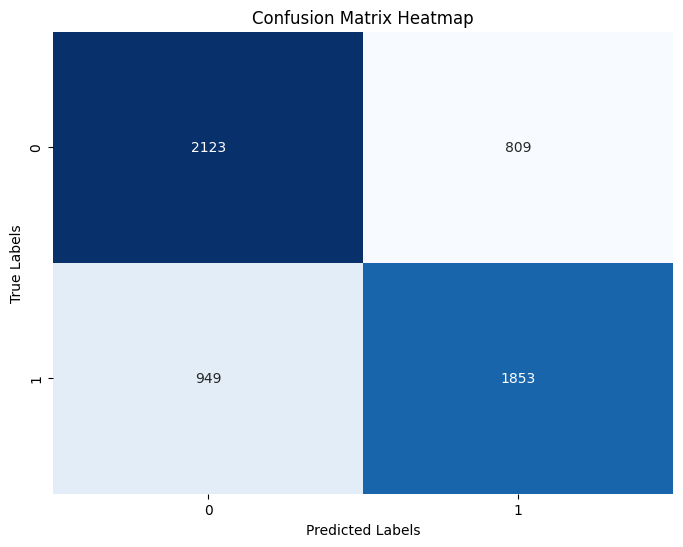

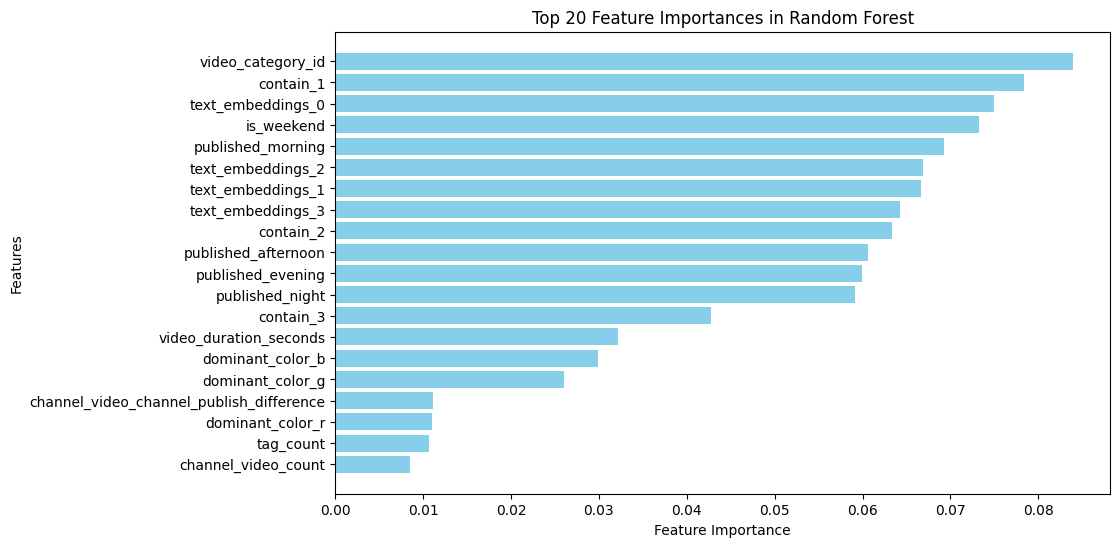

,Feature Prefix,Total Importance
0,text_embeddings,0.272771


In [28]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = MinMaxScaler()
X_train_mmx = np.hstack((X_train_numerical, X_train_encode,X_train_text))
X_test_mmx = np.hstack((X_test_numerical, X_test_encode, X_test_text))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

feature_names = pd.concat([data[categorical_features],data[numerical_features],data[embedded_text_columns]]).columns
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

importance_df['Prefix'] = importance_df['Feature'].str.extract(r'(text_embeddings)')

# Group by the extracted prefix and sum the importance values
aggregated_importance = importance_df.groupby('Prefix')['Importance'].sum().reset_index()

# Rename columns for clarity
aggregated_importance.columns = ['Feature Prefix', 'Total Importance']
aggregated_importance

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming you already have:
# X_train_mmx, y_train, X_test_mmx, y_test
# where X_* are NumPy arrays and y_* are NumPy arrays of shape (num_samples,)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_mmx, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # For binary classification as float
X_test_tensor = torch.tensor(X_test_mmx, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [147]:
class YoutubeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

In [148]:
train_dataset = YoutubeDataset(X_train_tensor, y_train_tensor)
test_dataset = YoutubeDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [152]:
class ImprovedMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 256, 128]):
        super(ImprovedMLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))  # Batch Normalization
            layers.append(nn.GELU())  # Activation function (GELU instead of ReLU)
            layers.append(nn.Dropout(0.2))  # Dropout for regularization
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer for binary classification
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

input_dim = X_train_mmx.shape[1]
model = ImprovedMLPClassifier(input_dim=input_dim, hidden_dims=[128, 256, 128])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [155]:
epochs = 100
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        outputs = outputs.squeeze()  # remove extra dimension if needed
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/100], Loss: 0.6352
Epoch [2/100], Loss: 0.6163
Epoch [3/100], Loss: 0.6119
Epoch [4/100], Loss: 0.6062
Epoch [5/100], Loss: 0.6030
Epoch [6/100], Loss: 0.6011
Epoch [7/100], Loss: 0.5979
Epoch [8/100], Loss: 0.5951
Epoch [9/100], Loss: 0.5896
Epoch [10/100], Loss: 0.5894
Epoch [11/100], Loss: 0.5862
Epoch [12/100], Loss: 0.5840
Epoch [13/100], Loss: 0.5790
Epoch [14/100], Loss: 0.5806
Epoch [15/100], Loss: 0.5737
Epoch [16/100], Loss: 0.5722
Epoch [17/100], Loss: 0.5687
Epoch [18/100], Loss: 0.5674
Epoch [19/100], Loss: 0.5628
Epoch [20/100], Loss: 0.5592
Epoch [21/100], Loss: 0.5557
Epoch [22/100], Loss: 0.5539
Epoch [23/100], Loss: 0.5517
Epoch [24/100], Loss: 0.5497
Epoch [25/100], Loss: 0.5479
Epoch [26/100], Loss: 0.5420
Epoch [27/100], Loss: 0.5394
Epoch [28/100], Loss: 0.5385
Epoch [29/100], Loss: 0.5346
Epoch [30/100], Loss: 0.5345
Epoch [31/100], Loss: 0.5272
Epoch [32/100], Loss: 0.5283
Epoch [33/100], Loss: 0.5245
Epoch [34/100], Loss: 0.5207
Epoch [35/100], Loss: 0

In [156]:
model.eval()
with torch.no_grad():
    # Get predictions for test set
    outputs = model(X_test_tensor).squeeze()
    probs = torch.sigmoid(outputs)
    preds = (probs >= 0.5).int()

# Convert predictions and true labels to numpy arrays
preds_np = preds.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Evaluate metrics
acc = accuracy_score(y_test_np, preds_np)
print(f"Test Accuracy: {acc:.4f}")
print(confusion_matrix(y_test_np, preds_np))
print(classification_report(y_test_np, preds_np))

Test Accuracy: 0.6526
[[2025  907]
 [1085 1717]]
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      2932
         1.0       0.65      0.61      0.63      2802

    accuracy                           0.65      5734
   macro avg       0.65      0.65      0.65      5734
weighted avg       0.65      0.65      0.65      5734

